In [1]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import ast

from scipy.stats import spearmanr, pearsonr

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def load_data(data_file, drop_cols=['Preamble'], convert_prob=True):
    data = pd.read_csv(data_file, sep='|')
    data = data.drop(drop_cols, axis=1)

    try:
        data['stimulus_prob'] = [[t for t in m] for m in data['stimulus_prob'].apply(ast.literal_eval)]
    except ValueError as e:
        for m in data['stimulus_prob']:
            print(m)
        print(data['stimulus_prob'])
        return None
    
    if convert_prob:
        data['stimulus_prob'] = [[(2 ** t) for t in m] for m in data['stimulus_prob']]

    return pd.DataFrame(data)

In [7]:
def split_confusion_matrix(df):
    test_pos = df.loc[(df['Dependent_Variable'] == 'present')]
    test_neg = df.loc[(df['Dependent_Variable'] == 'absent')]

    true_neg  = test_neg.loc[(test_neg['True_Category'] ==  'absent')].reset_index()
    false_pos = test_pos.loc[(test_pos['True_Category'] ==  'absent')].reset_index()
    false_neg = test_neg.loc[(test_neg['True_Category'] == 'present')].reset_index()
    true_pos  = test_pos.loc[(test_pos['True_Category'] == 'present')].reset_index()

    # Decided to return in the same order expected from sklearn confusion_matrix function
    return true_neg, false_pos, false_neg, true_pos

In [24]:
def confusion_scatter(df, fan_type = 'both', aggregate='none'):
    if fan_type == 'both':
        fan = lambda a, b : (a*a + b*b)**(1/2)
    elif fan_type == 'first':
        fan = lambda a, b : a
    elif fan_type == 'second':
        fan = lambda a, b : b

    def fill_subplot(ax, df_part : pd.DataFrame, lab):
        x = []
        y = []

        for _, row in df_part.iterrows():
            fan_per = row['Fan_Person']
            fan_pla = row['Fan_Place']
            probs = row['stimulus_prob']

            if len(probs) != 50:
                raise ValueError

            if aggregate == 'none':
                x = x + [fan(fan_per, fan_pla)] * len(probs)
                y = y + probs
            elif aggregate == 'mean':
                x = x + [fan(fan_per, fan_pla)]
                y = y + [np.mean(probs)]
            elif aggregate == 'std':
                x = x + [fan(fan_per, fan_pla)]
                y = y + [np.std(probs)]

        x, y = np.asarray(x), np.asarray(y)

        m, b = np.polyfit(x, y, 1)
        # r, p = spearmanr(x, y)

        # z = spearmanr(x, y)
        z = pearsonr(x, y)
        r = z.statistic
        p = z.pvalue

        # ax.scatter(x,y, color=(0,0,0,max(0.1,1/len(x))))

        bins = dict()
        for x_i, y_i in zip(x,y):
            try:
                bins[x_i].append(y_i)
            except KeyError:
                bins[x_i] = [y_i]

        sorted_x = list(sorted(list(set(x))))
        new_y = [bins[k] for k in sorted_x]


        ax.violinplot(new_y, [50 * k for k in sorted_x])

        ax.plot(x, m*x + b, color='red')
        ax.text(0.01,0.01, f'r={r:.3f}, p={p:.3f} g={lab}', color='red', transform=ax.transAxes)

    tn, fp, fn, tp = split_confusion_matrix(df)

    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))

    fill_subplot(axes[0][0], tp, 'tp')
    # fill_subplot(axes[0][1], fn, 'fn')
    # fill_subplot(axes[1][0], fp, 'fp')
    # fill_subplot(axes[1][1], tn, 'tn')

    plt.show()

In [15]:
def per_pop_corr (df, fan_type = 'both'):
    if fan_type == 'both':
        fan = lambda a, b : (a*a + b*b)**(1/2)
    elif fan_type == 'first':
        fan = lambda a, b : a
    elif fan_type == 'second':
        fan = lambda a, b : b

    _, _, _, df_part = split_confusion_matrix(df)

    # fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
    # fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10))


    pop_size = len(df_part['stimulus_prob'][0])
    x = []
    y_list = [[] for _ in range(pop_size)]

    for _, row in df_part.iterrows():
        fan_per = row['Fan_Person']
        fan_pla = row['Fan_Place']
        probs = row['stimulus_prob']

        x = x + [fan(fan_per, fan_pla)]
        for i in range(pop_size):
            y_list[i].append(probs[i])

    # x, y = np.asarray(x), np.asarray(y)

    # m, b = np.polyfit(x, y, 1)

    rs, ps = [], []
    # z = spearmanr(x, y)
    # z = pearsonr(x, y)
    # r = z.statistic
    # p = z.pvalue

    for i in range(pop_size):
        # z = spearmanr(x, y_list[i])
        z = pearsonr(x, y_list[i])
        rs.append(z.statistic)
        ps.append(z.pvalue)

    return rs, ps

    ax.scatter(x,y, color=(0,0,0,max(0.1,1/len(x))))
    ax.plot(x, m*x + b, color='red')
    ax.text(0.01,0.01, f'r={r:.3f}, p={p:.3f} g=tp', color='red', transform=ax.transAxes)

    ax.set_xlabel('Fan Level')
    ax.set_ylabel('Probability')
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)


    plt.show()

In [13]:
models = [
    # 'LLaMa2-7B',
    # 'LLaMa3-8B',
    # 'LLaMa3-8B-Instruct',
    'Mistral-7B',
]

In [14]:
for mod in models:
    df = load_data(f'../data/Random_TP_Only/results_{mod}.csv', convert_prob=True)
    exp_rs, exp_ps = per_pop_corr(df, fan_type='both')
    print(f'Model: {mod}\tfan type: both')
    print(np.asarray(exp_rs))
    print(np.mean(exp_rs))
    print(np.std(exp_rs))

    exp_rs, exp_ps = per_pop_corr(df, fan_type='first')
    print(f'Model: {mod}\tfan type: first')
    print(np.asarray(exp_rs))
    print(np.mean(exp_rs))
    print(np.std(exp_rs))

    exp_rs, exp_ps = per_pop_corr(df, fan_type='second')
    print(f'Model: {mod}\tfan type: second')
    print(np.asarray(exp_rs))
    print(np.mean(exp_rs))
    print(np.std(exp_rs))

    print()

Model: Mistral-7B	fan type: both
[ 0.19320967 -0.08531719 -0.03179376 -0.05794113  0.03376218  0.1017205
  0.09534449 -0.0807474  -0.00940962  0.07866845 -0.15177896  0.05728021
  0.14654931  0.02468026 -0.04656032 -0.1431871  -0.12100492  0.11230079
 -0.04975203 -0.09599357 -0.07020197  0.17081455  0.07075044 -0.09447636
  0.03155074  0.03236617  0.01400544 -0.18827765 -0.08805269 -0.05621121
 -0.09777872 -0.06198701 -0.09048685 -0.03011882  0.01754524 -0.16258652
 -0.03816583 -0.10143271  0.00253817  0.20512852 -0.0118821  -0.09113057
  0.14240711 -0.05902121 -0.01255551 -0.07008525  0.19008589  0.02688747
 -0.0996705  -0.08126137]
-0.01262546514204812
0.09744529477638394
Model: Mistral-7B	fan type: first
[0.40550459 0.16974801 0.19307341 0.13864666 0.24811007 0.36172074
 0.31195985 0.11685281 0.22279606 0.29171381 0.07111547 0.19769792
 0.33479975 0.24544463 0.11379459 0.13409034 0.07833515 0.33607598
 0.20409649 0.10299278 0.17275408 0.33259485 0.3085668  0.09168838
 0.1878779  0.2

In [9]:
rand_mist = load_data('../data/Random/results_Mistral-7B.csv', convert_prob=True)

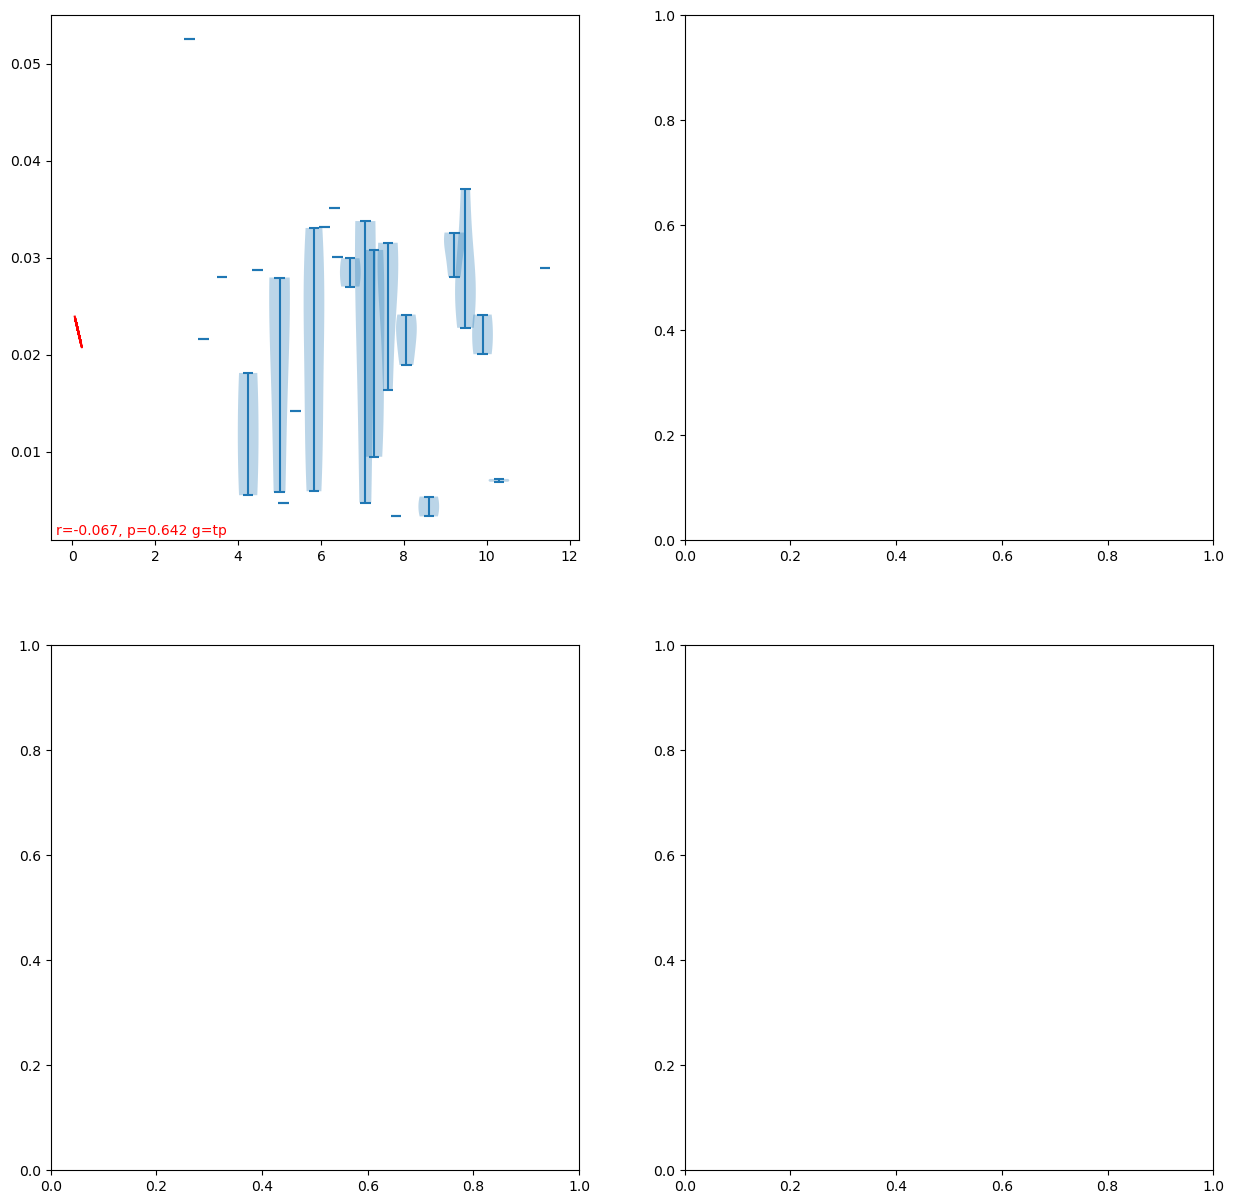

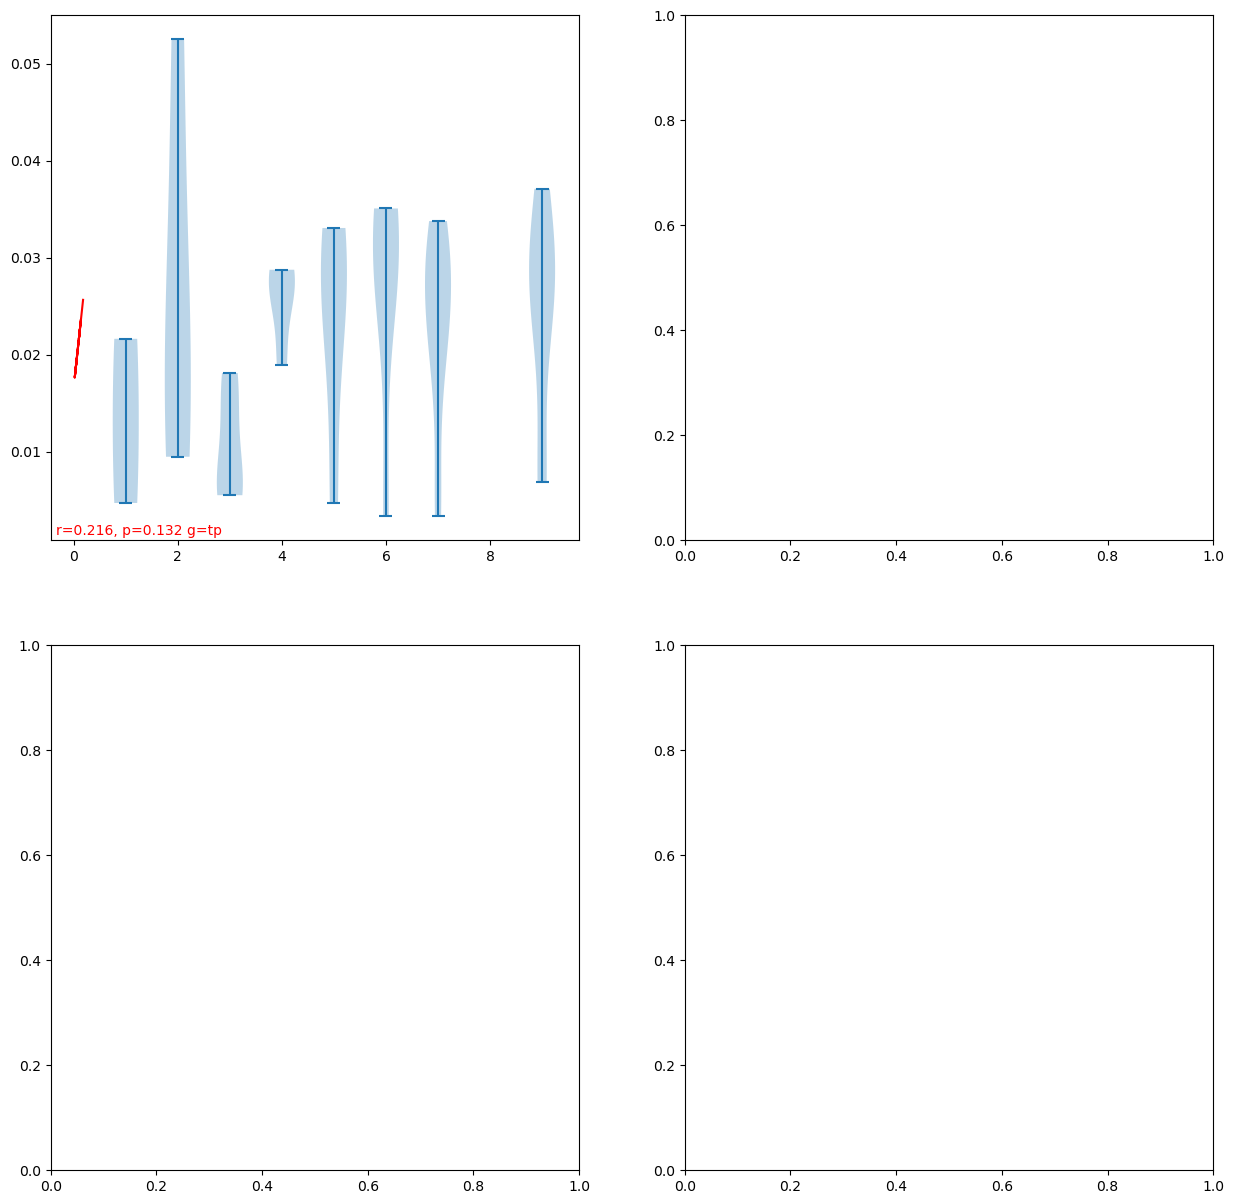

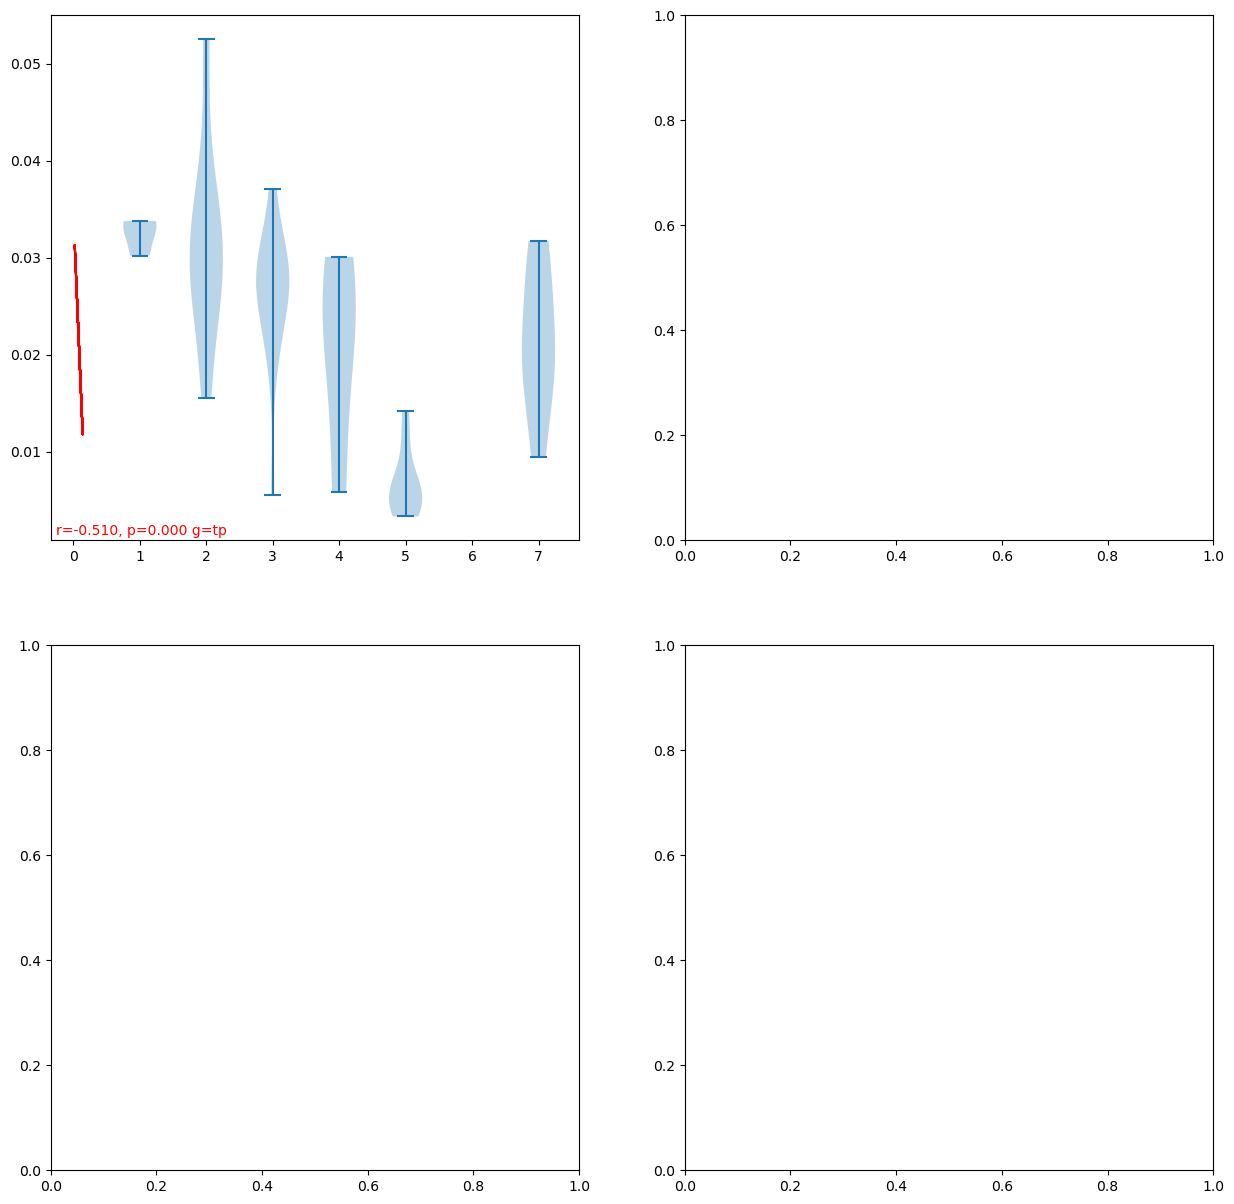

In [25]:
rand_mist = load_data('../data/Random_TP_Only/results_Mistral-7B.csv', convert_prob=True)
confusion_scatter(rand_mist, fan_type='both', aggregate='std')
confusion_scatter(rand_mist, fan_type='first', aggregate='std')
confusion_scatter(rand_mist, fan_type='second', aggregate='std')